In [1]:
### 常规分析包
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
### 其他
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
meta = pd.read_csv('../Data_preprocess/1.1.MetaData.tsv', sep='\t', index_col=0)
meta.head(2)
#data = pd.read_csv('../Data/16S/MZJ_dada2_table_ASV.tsv', sep='\t', index_col=0, skiprows=1)
data = pd.read_csv('../Data/16S/DADA2_table/MZJ_dada2_table_L6.tsv', sep='\t', index_col=0, skiprows=1)
data.columns = [i if i!='11_10' else 'C11_10' for i in data.columns]

data.shape
data.head(2)

,SampleID,SampleID_1,Child_ID,Sample_type,Day,Time,MotherID,WMS,Gender,Mode of delivery,...,Day of the last sample,Number of samples,Day of introducing solid food,Day of breastfeeding cessation,Solid food,Breastfeeding,"Feeding mode(BFD:0,MFD:1)","Sibling(Y:1,N:0)","PAE(Y:1,N:0)","Allergy(Y:1,N:0)"
ID,,,,,,,,,,,,,,,,,,,,,
C11_10,11_10,D_10,11,C,25.0,T10,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0
C11_11,11_11,D_11,11,C,29.0,T11,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0


(511, 466)

,C11_10,C1_11,C1_12,C1_13,C1_14,C1_15,C1_16,C1_2,C1_21,C1_22,...,M21_M,M25_M,M26_M,M28_M,M29_M,M31_M,M32_M,M34_M,M35_M,M4_M
#OTU ID,,,,,,,,,,,,,,,,,,,,,
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;__,10611.0,247.0,699.0,1819.0,421.0,194.0,2550.0,9995.0,7853.0,1220.0,...,0.0,0.0,0.0,0.0,0.0,23.0,4733.0,16.0,116.0,99.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;__,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# SparCC

In [3]:
sparcc = pd.read_csv('../Results_0609/6.4. SparCC.tsv', sep='\t', index_col=0)
sparcc.head(1)
len(set(sparcc['t1'])), len(set(sparcc['t2'])), len(set(data.index))

,t1,t2,cor,p
1,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,-0.117867,0.036


(221, 221, 511)

In [32]:
net = sparcc.loc[(sparcc['cor'].abs()>=0.15)&(sparcc['p']<=0.05), :]
net.shape
nodes_set = set()
links_set = set()
nodes = []
links = []
for i in net.index:
    t1 = net.loc[i, 't1']
    t2 = net.loc[i, 't2']
    r = net.loc[i, 'cor']
    p = net.loc[i, 'p']
    if t1 not in nodes_set:
        nodes_set.add(t1)
        phylum = 'Others' if 'p__' not in t1 else t1.split(';p__')[1].split(';c__')[0]
        nodes.append([t1, phylum])
    if t2 not in nodes_set:
        nodes_set.add(t2)
        phylum = 'Others' if 'p__' not in t2 else t2.split(';p__')[1].split(';c__')[0]
        nodes.append([t2, phylum])
    if tuple(sorted([t1, t2])) not in links_set:
        links_set.add(tuple(sorted([t1, t2])))
        links.append([t1, t2, r, p, abs(r), np.sign(r)])
nodes = pd.DataFrame(nodes, columns=['NID', 'Phylum'])
links = pd.DataFrame(links, columns=['source', 'target', 'r', 'p', 'absr', 'signr'])

(689, 4)

In [33]:
nodes.to_csv('../Results_0609/6.4. SparCC_nodes.csv')
links.to_csv('../Results_0609/6.4. SparCC_links.csv')

(0.4588570635132786, 1.9514726366267532e-12)

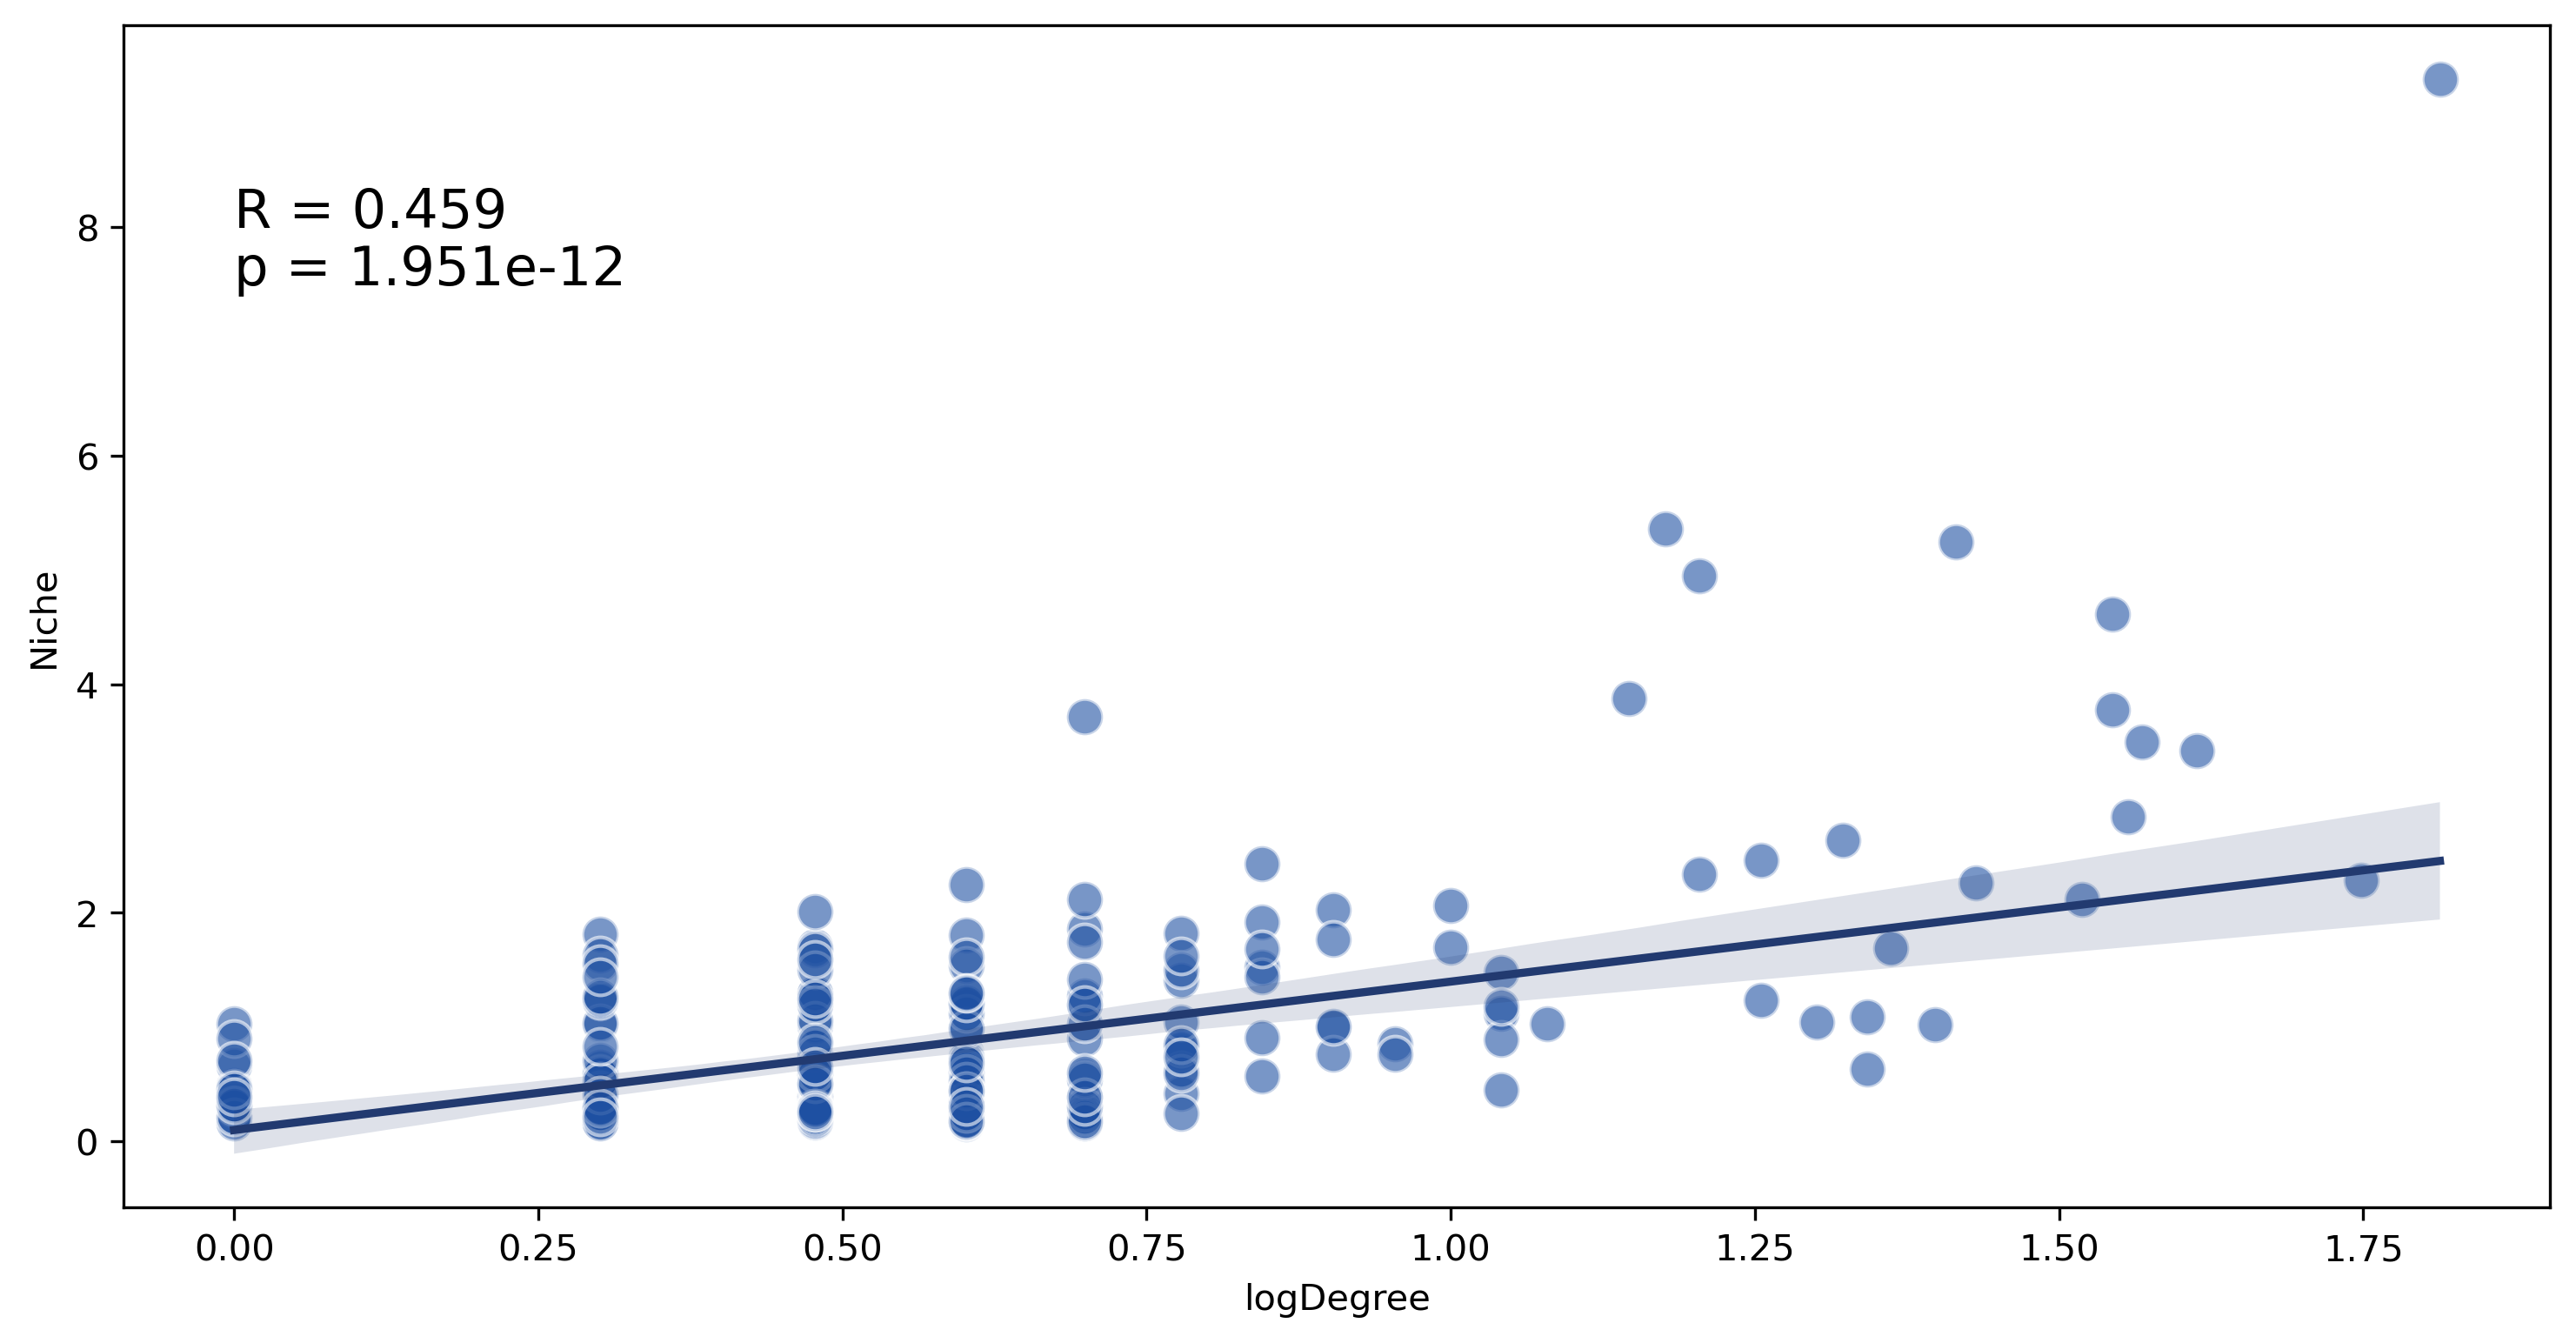

In [6]:
niche = pd.read_csv('../Results_0609/5.2. Genus生态位宽度.csv', index_col=0)
niche = niche.replace(np.inf, 0)
#niche.max()
degree = pd.read_csv('../Results_0609/6.4. SparCC_r0.15_degree.csv', index_col='name')
#degree.head(2)

genus = set(niche.columns)&set(degree.index)
result = []
for g in genus:
    result.append([g, degree.loc[g, 'Degree'], niche[g].mean()])
result = pd.DataFrame(result, columns=['Genus', 'Degree', 'Niche'])
result['logDegree'] = np.log10(result['Degree'])
#result
r, p = spearmanr(result['logDegree'], result['Niche'])
r, p
fig = plt.figure(figsize=(12, 6), dpi=300)
_ = sns.regplot(x="logDegree", y="Niche", data=result, lowess=False, robust=True, 
                line_kws={'color':'#223a70'}, scatter_kws={'color':'#1e50a2', 's':100, 'alpha':0.6, 'ec':'white'})
_ = plt.annotate('R = 0.459', (0.0, 8), fontsize=15)
_ = plt.annotate('p = 1.951e-12', (0.0, 7.5), fontsize=15)
fig.savefig('../Results_0609/6.4. Degree和生态位宽度（mean）关系.pdf', dpi=300)